In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


raw_dir = "/Users/houleyeanne/Documents/FinSent/data/raw/"
cleaned_dir = "/Users/houleyeanne/Documents/FinSent/data/cleaned/"

def load_csv(directory, filename, *, date_col=None, date_format=None):
    filepath = os.path.join(directory, filename)
    df = pd.read_csv(filepath)

    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors="coerce")
    return df


def basic_clean(df, date_col=None):
    """
    - suppression des doublons
    - drop des lignes avec Date vide
    """
    df = df.drop_duplicates()
    if date_col and date_col in df.columns:
        df = df.dropna(subset=[date_col])
    return df


In [2]:
# Prix Kaggle (flat files)
df_prices = load_csv(cleaned_dir, "all_stock_prices.csv", date_col="Date")
df_prices = basic_clean(df_prices, date_col="Date")

# GDELT
df_gdelt = load_csv(raw_dir, "gdelt_events.csv", date_col="SQLDATE", date_format="%Y%m%d")
df_gdelt = df_gdelt.rename(columns={"SQLDATE": "Date"})
df_gdelt = basic_clean(df_gdelt, date_col="Date")
df_gdelt["Actor1Name"] = df_gdelt["Actor1Name"].fillna("UNKNOWN")
df_gdelt["Actor2Name"] = df_gdelt["Actor2Name"].fillna("UNKNOWN")

# Yahoo Finance (scraping)
df_news = load_csv(raw_dir, "yahoo_finance_news.csv", date_col="date")
df_news = basic_clean(df_news, date_col="date")

# API
df_api = load_csv(raw_dir, "stock_prices_api.csv", date_col="Date")
df_api = basic_clean(df_api, date_col="Date")


In [3]:
df_prices.to_csv("/Users/houleyeanne/Documents/FinSent/data/cleaned/all_stock_prices_cleaned.csv", index=False)
df_gdelt.to_csv("/Users/houleyeanne/Documents/FinSent/data/cleaned/gdelt_events_cleaned.csv", index=False)
df_news.to_csv("/Users/houleyeanne/Documents/FinSent/data/cleaned/yahoo_finance_news_cleaned.csv", index=False)
df_api.to_csv("/Users/houleyeanne/Documents/FinSent/data/cleaned/stock_prices_api_cleaned.csv", index=False)

In [3]:
# Pour df_prices (Kaggle)
df_prices = df_prices.sort_values(["Ticker" if "Ticker" in df_prices.columns else "Date", "Date"])
df_prices["Return"] = df_prices["Close"].pct_change()


# Pour df_api (Yahoo API par ticker)
df_api = df_api.sort_values(["Ticker", "Date"])
df_api["Return"] = df_api.groupby("Ticker")["Close"].pct_change()


===== EDA df_prices (filtered) =====

📊 Univariate stats for Close:
count     6461.000000
mean      2695.365392
std       8153.545074
min         -0.105000
25%        109.895294
50%        196.770004
75%       1616.599976
max      63503.457031
Name: Close, dtype: float64


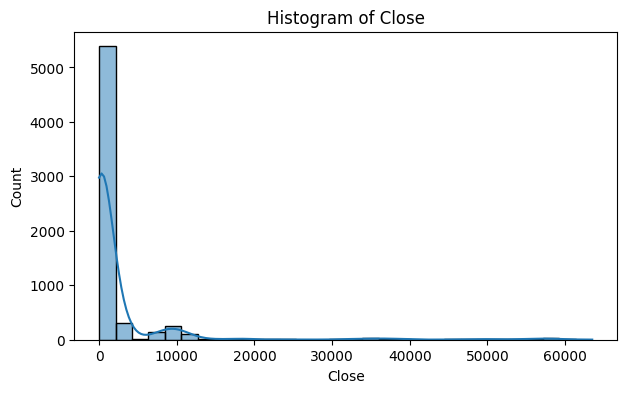


📊 Univariate stats for Volume:
count    6.461000e+03
mean     4.206287e+09
std      1.373588e+10
min      0.000000e+00
25%      3.104600e+06
50%      1.525610e+07
75%      5.733440e+07
max      3.509679e+11
Name: Volume, dtype: float64


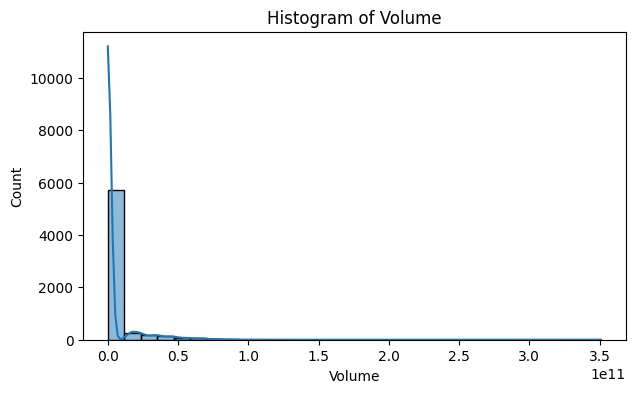


📊 Univariate stats for Return:
count    6.460000e+03
mean     4.039601e+03
std      3.937289e+04
min     -6.717707e+04
25%     -7.761691e-01
50%      5.473994e-02
75%      4.664450e+00
max      1.155806e+06
Name: Return, dtype: float64


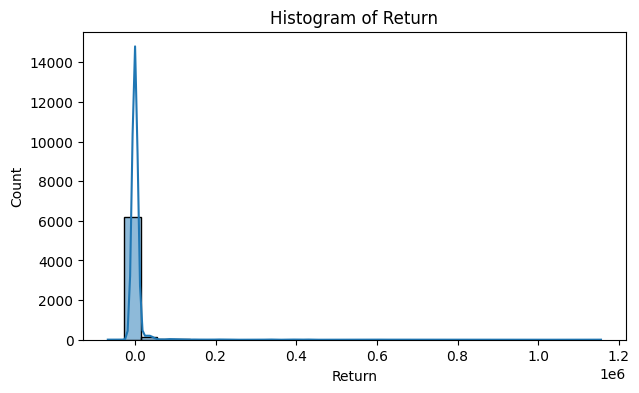


🔗 Filtered Correlation matrix:
           Close    Volume    Return
Close   1.000000  0.847144  0.006401
Volume  0.847144  1.000000 -0.030859
Return  0.006401 -0.030859  1.000000


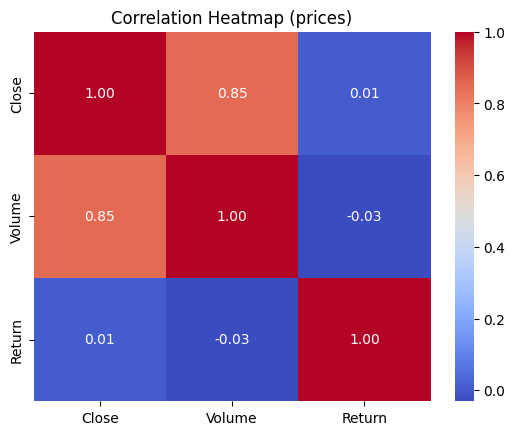

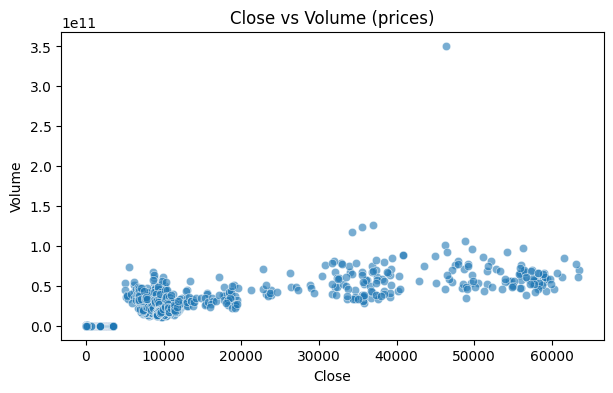

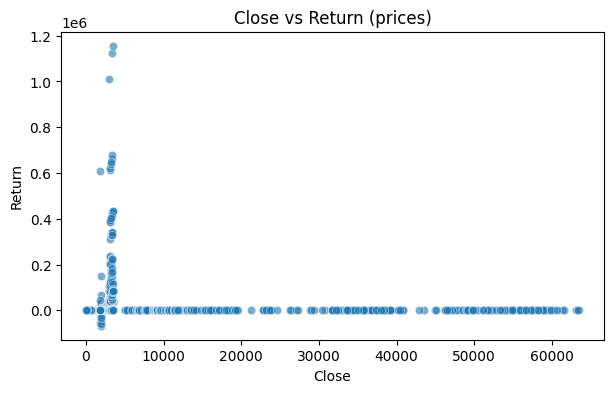

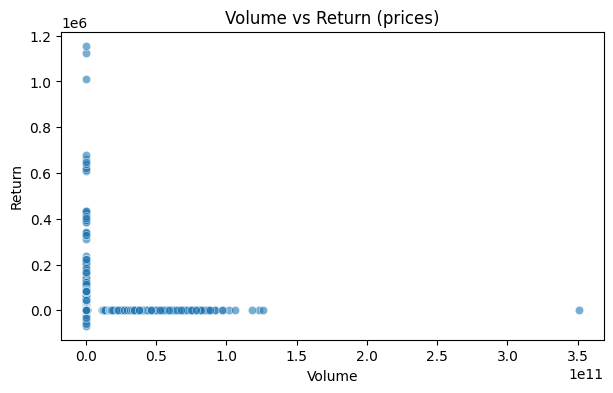

===== EDA df_api (filtered) =====

📊 Univariate stats for Close:
count     88.000000
mean     329.070076
std      116.349749
min      200.011230
25%      230.892723
50%      285.934990
75%      443.144989
max      516.251282
Name: Close, dtype: float64


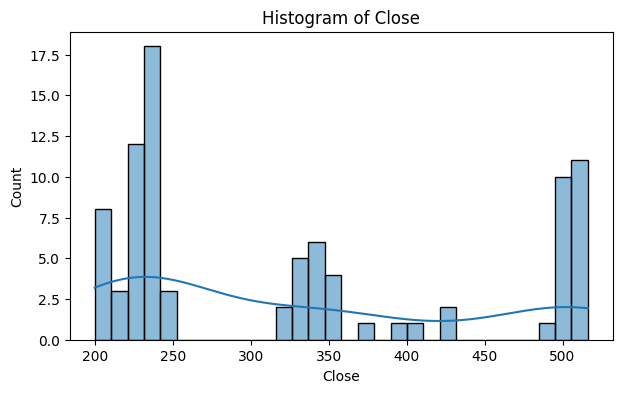


📊 Univariate stats for Volume:
count    8.800000e+01
mean     4.469395e+07
std      3.184673e+07
min      1.176890e+07
25%      2.122185e+07
50%      3.162715e+07
75%      6.138852e+07
max      1.681564e+08
Name: Volume, dtype: float64


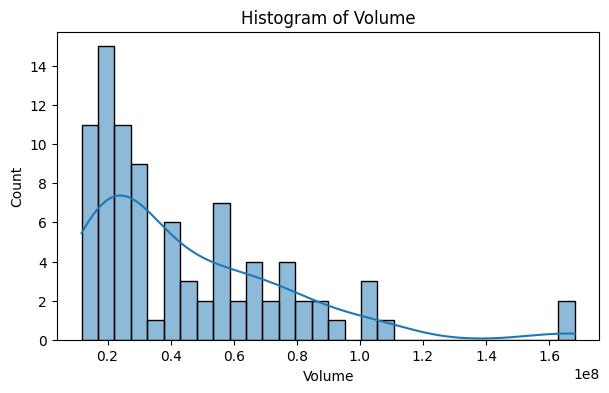


📊 Univariate stats for Return:
count    84.000000
mean      0.005748
std       0.020794
min      -0.035002
25%      -0.005863
50%       0.002256
75%       0.011378
max       0.090146
Name: Return, dtype: float64


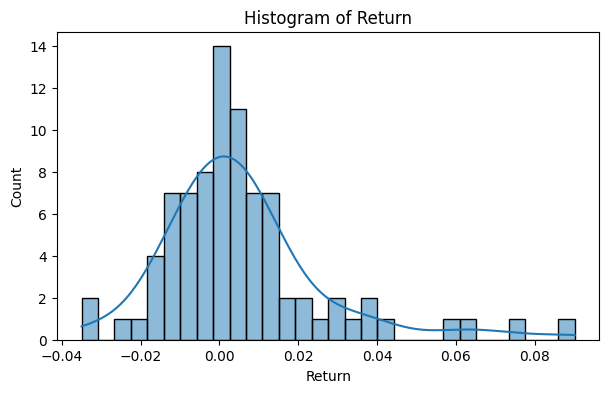


🔗 Filtered Correlation matrix:
           Close    Volume    Return
Close   1.000000 -0.039876 -0.045338
Volume -0.039876  1.000000  0.414195
Return -0.045338  0.414195  1.000000


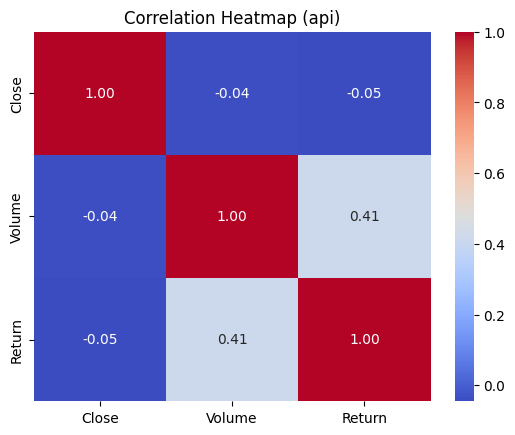

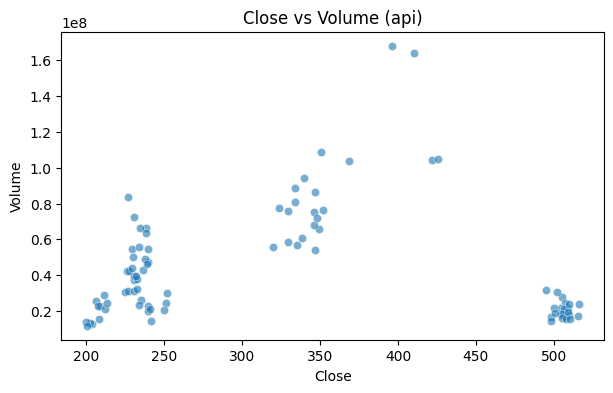

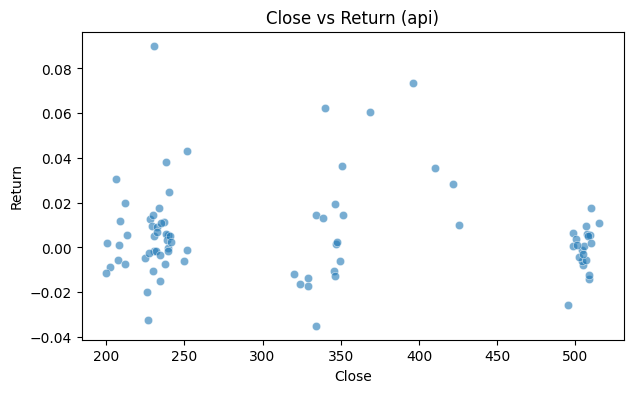

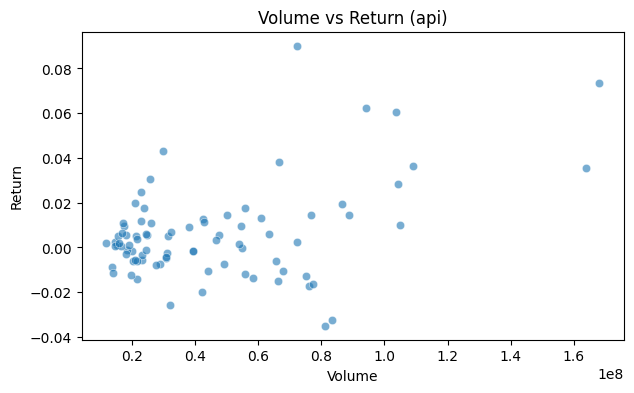

===== EDA df_gdelt (filtered) =====

📊 Univariate stats for GoldsteinScale:
count    461.000000
mean       1.287419
std        4.008292
min      -10.000000
25%        0.000000
50%        1.900000
75%        3.400000
max       10.000000
Name: GoldsteinScale, dtype: float64


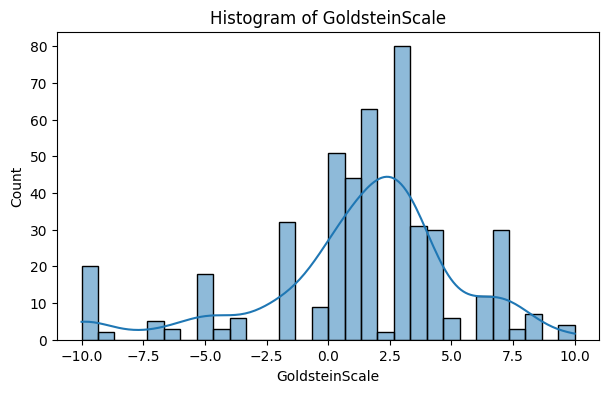


📊 Univariate stats for AvgTone:
count    461.000000
mean      -0.875910
std        3.850170
min      -13.207547
25%       -2.962963
50%       -0.746114
75%        1.785714
max        9.302326
Name: AvgTone, dtype: float64


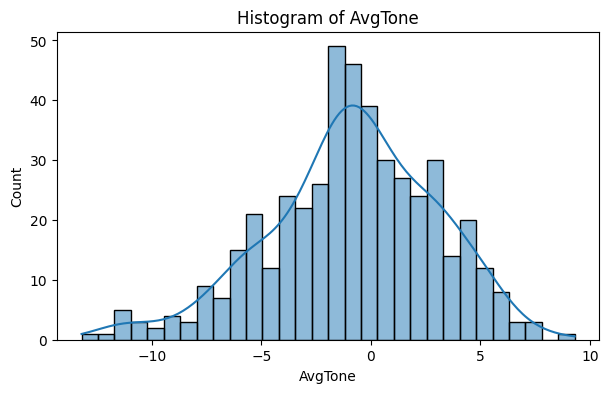


🔗 Filtered Correlation matrix:
                GoldsteinScale  AvgTone
GoldsteinScale         1.00000  0.31179
AvgTone                0.31179  1.00000


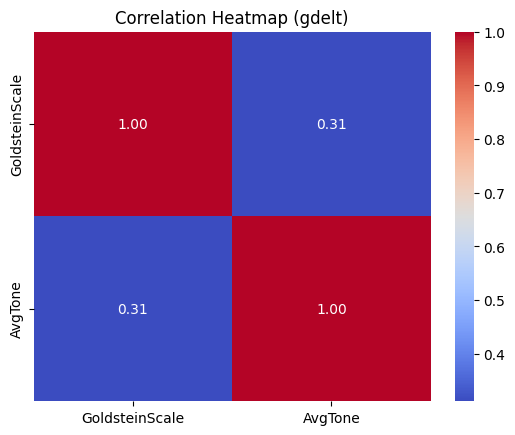

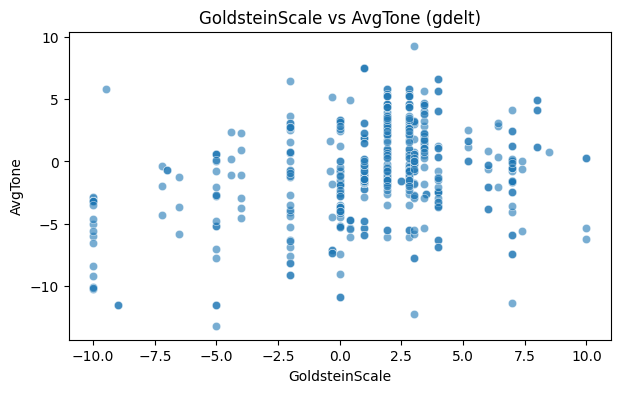

In [7]:
def eda_numerical_filtered(df, dataset=""):
    """
    Analyse univariée et bivariée pour colonnes numériques (version filtrée)
    Ne conserve que les variables pertinentes pour les corrélations.
    """

    # Choix des colonnes pertinentes par dataset
    if dataset == "prices":
        num_cols = ["Close", "Volume", "Return"]
    elif dataset == "api":
        num_cols = ["Close", "Volume", "Return"]
    elif dataset == "gdelt":
        num_cols = ["GoldsteinScale", "AvgTone"]
    else:
        num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

    # --- Univariée ---
    for col in num_cols:
        print(f"\n📊 Univariate stats for {col}:")
        print(df[col].describe())
        plt.figure(figsize=(7,4))
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(f"Histogram of {col}")
        plt.show()
    
    # --- Corrélations bivariées ---
    if len(num_cols) > 1:
        corr = df[num_cols].corr()
        print("\n🔗 Filtered Correlation matrix:")
        print(corr)
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title(f"Correlation Heatmap ({dataset})")
        plt.show()
        
        # Scatter plots uniquement pour colonnes pertinentes
        for i in range(len(num_cols)):
            for j in range(i+1, len(num_cols)):
                plt.figure(figsize=(7,4))
                sns.scatterplot(x=df[num_cols[i]], y=df[num_cols[j]], alpha=0.6)
                plt.title(f"{num_cols[i]} vs {num_cols[j]} ({dataset})")
                plt.show()


# ------------------------------
# Application adaptée
# ------------------------------

print("===== EDA df_prices (filtered) =====")
eda_numerical_filtered(df_prices, dataset="prices")

print("===== EDA df_api (filtered) =====")
eda_numerical_filtered(df_api, dataset="api")

print("===== EDA df_gdelt (filtered) =====")
eda_numerical_filtered(df_gdelt, dataset="gdelt")


| Dataset        | Variable                | Type        | Analyse univariée                                 | Analyse bivariée / multivariée                                      | Notes pour rapport/oral                 |
| -------------- | ----------------------- | ----------- | ------------------------------------------------- | ------------------------------------------------------------------- | --------------------------------------- |
| **df\_prices** | Date                    | datetime    | Range, min, max, nombre de jours                  | Utiliser pour grouper par mois/trimestre                            | Pour visualiser période des données     |
|                | Open, High, Low, Close  | numérique   | mean, median, std, min, max, histograms, boxplots | Corrélations entre colonnes, scatter `Close vs Open`, `High vs Low` | Mettre en évidence patterns et outliers |
|                | Volume                  | numérique   | mean, median, histograms                          | Scatter `Volume vs Close` ou `Volume vs Return`                     | Fort lien avec performance journalière  |
|                | Dividends, Stock Splits | numérique   | mean, min, max, histogram                         | Peu utile bivarié sauf pour analyse spécifique                      | Vérifier distribution                   |
| **df\_gdelt**  | Date                    | datetime    | Range, min, max                                   | Grouper par mois/année pour visualisation temporelle                | Pour suivi temporel des événements      |
|                | EventCode               | catégorique | value\_counts, bar chart                          | AvgTone ou GoldsteinScale par EventCode                             | Montre répartition types d’événements   |
|                | GoldsteinScale          | numérique   | mean, median, std, min, max, histogram            | Scatter `GoldsteinScale vs AvgTone`                                 | Permet mesurer impact des événements    |
|                | AvgTone                 | numérique   | mean, median, std, histogram                      | Scatter vs GoldsteinScale ou corrélation avec Stock Returns         | Indique sentiment général               |
|                | Actor1Name, Actor2Name  | catégorique | value\_counts                                     | Peu utile pour corrélation, mais on peut grouper par acteur         | Pour analyse des acteurs principaux     |
| **df\_news**   | date                    | datetime    | min, max, range                                   | Grouper par mois/année pour volume d’articles                       | Montre couverture temporelle            |
|                | title, body             | texte       | longueur, nombre de mots                          | -                                                                   | Pour analyse sentiment / NLP            |
|                | source                  | catégorique | value\_counts                                     | -                                                                   | Pour distribution par source            |
| **df\_api**    | Date                    | datetime    | range, min, max                                   | Grouper par mois/année                                              | Pour suivi temporel                     |
|                | Close, High, Low, Open  | numérique   | mean, median, std, min, max, histogram            | Corrélation entre colonnes, scatter `Volume vs Close`               | Même logique que df\_prices             |
|                | Volume                  | numérique   | histogram, stats descriptives                     | Scatter `Volume vs Close` ou `Volume vs Return`                     | Important pour trading activity         |
|                | Ticker                  | catégorique | value\_counts                                     | Boxplot `Close` ou `Return` par ticker                              | Analyse comparative par action          |
